In [1]:
import os
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM,Dense
from keras.backend import clear_session
import tensorflow as tf

warnings.simplefilter('ignore')
plt.style.use('fivethirtyeight')

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Aug  1 10:54:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    48W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

GPU is available


In [4]:
data_dir = Path('data')

df = pd.read_csv(
    data_dir / 'SPP_MSFT.csv',
    usecols=['DNCP','MPN5P']
)

df['DATE'] = pd.to_datetime(df['DNCP'], origin='1899-12-30', unit='D')
df = df.drop('DNCP',axis=1)
df = df.set_index('DATE')

df.shape

(5877, 1)

In [5]:
dataset = df.values
dataset = dataset.astype('float32')

#normalize
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

# train test split
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train,test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

print(len(train), len(test))

3937 1940


In [6]:
def create_dataset(dataset,look_back=1):
    X,y = [],[]
    for i in range(len(dataset) - look_back):
        features = dataset[i:(i+look_back),0]
        target = dataset[i+look_back,0]
        X.append(features)
        y.append(target)

    return np.array(X), np.array(y)

look_back = 60
X_train, y_train = create_dataset(train, look_back=look_back)
X_test, y_test = create_dataset(test, look_back=look_back)

In [7]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(X_train.shape, X_test.shape)
print(y_train.shape,y_test.shape)

(3877, 60, 1) (1880, 60, 1)
(3877,) (1880,)


In [61]:
clear_session()

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='Adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, batch_size=1, verbose=2,epochs=20)

model.save('models/raw_features_lstmv1.h5')

Epoch 1/20
3877/3877 - 25s - loss: 2.4398e-05 - 25s/epoch - 6ms/step
Epoch 2/20
3877/3877 - 22s - loss: 7.6614e-06 - 22s/epoch - 6ms/step
Epoch 3/20
3877/3877 - 22s - loss: 5.5644e-06 - 22s/epoch - 6ms/step
Epoch 4/20
3877/3877 - 22s - loss: 4.2979e-06 - 22s/epoch - 6ms/step
Epoch 5/20
3877/3877 - 22s - loss: 3.2680e-06 - 22s/epoch - 6ms/step
Epoch 6/20
3877/3877 - 22s - loss: 3.5260e-06 - 22s/epoch - 6ms/step
Epoch 7/20
3877/3877 - 22s - loss: 2.8294e-06 - 22s/epoch - 6ms/step
Epoch 8/20
3877/3877 - 22s - loss: 2.7544e-06 - 22s/epoch - 6ms/step
Epoch 9/20
3877/3877 - 22s - loss: 2.5150e-06 - 22s/epoch - 6ms/step
Epoch 10/20
3877/3877 - 22s - loss: 2.2741e-06 - 22s/epoch - 6ms/step
Epoch 11/20
3877/3877 - 22s - loss: 2.4502e-06 - 22s/epoch - 6ms/step
Epoch 12/20
3877/3877 - 22s - loss: 2.5149e-06 - 22s/epoch - 6ms/step
Epoch 13/20
3877/3877 - 22s - loss: 2.0213e-06 - 22s/epoch - 6ms/step
Epoch 14/20
3877/3877 - 22s - loss: 2.7107e-06 - 22s/epoch - 6ms/step
Epoch 15/20
3877/3877 - 22s -

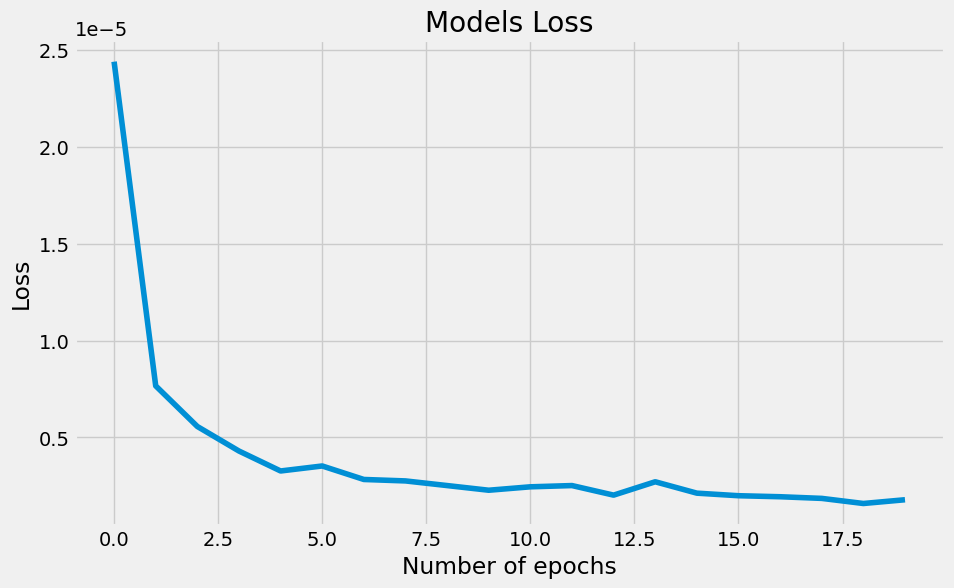

In [62]:
loss = history.history['loss']
epochs = range(len(loss))

plt.figure(figsize=(10,6))
plt.plot(epochs, loss, '-')
plt.title('Models Loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')

plt.show()

In [8]:
from keras.models import load_model

model = load_model('models/raw_features_lstmv1.h5')

In [9]:
fitted = model.predict(X_train)
preds = model.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train,fitted))
test_rmse = np.sqrt(mean_squared_error(y_test,preds))

print(f'Train rmse: {train_rmse}')
print(f'Test rmse: {test_rmse}')

y_train = scaler.inverse_transform(y_train.reshape(-1,1))
y_test = scaler.inverse_transform(y_test.reshape(-1,1))
fitted = scaler.inverse_transform(fitted)
preds = scaler.inverse_transform(preds)

59/59 [==============================] - 0s 3ms/step
Train rmse: 0.0008551431237719953
Test rmse: 0.13465774059295654


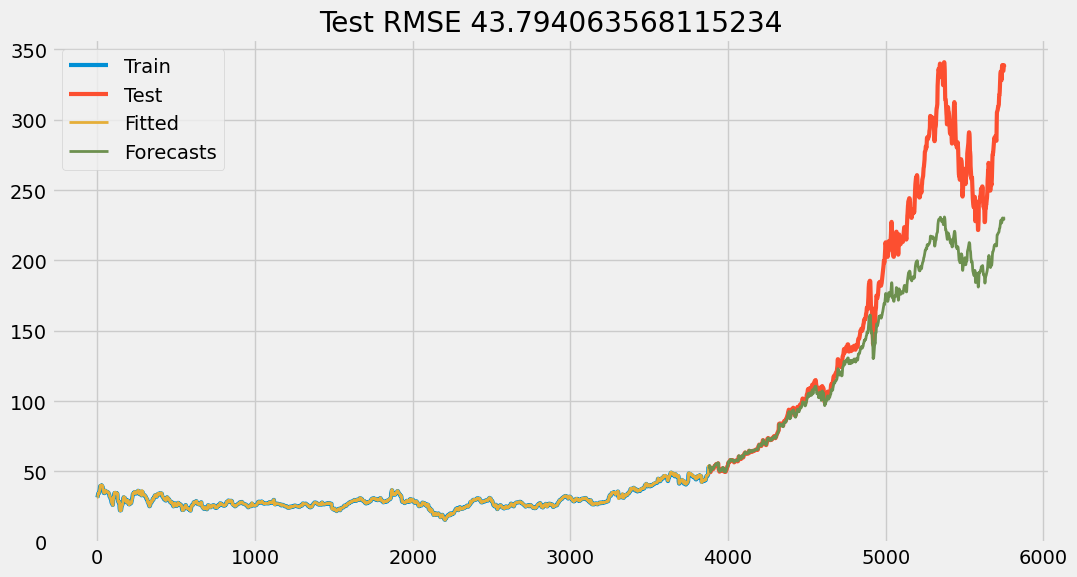

In [31]:
plt.rc("figure", autolayout=True, figsize=(11, 6))
#plt.rc('lines', linewidth=2.5)

y_train_series = pd.Series(y_train.flatten())
y_test_series = pd.Series(y_test.flatten(), index=np.arange(len(y_train), (len(y_train) + len(y_test))))

fitted_series = pd.Series(fitted.flatten(), index=y_train_series.index)
preds_series = pd.Series(preds.flatten(), index=y_test_series.index)

ax = y_train_series.plot(linewidth=3, label='Train')
ax = y_test_series.plot(ax=ax, linewidth=3, label='Test')
ax = fitted_series.plot(ax=ax, linewidth=2, label='Fitted')
_ = preds_series.plot(ax=ax, linewidth=2, label='Forecasts')

plt.title(f'Test RMSE: {mean_squared_error(y_test_series,preds_series,squared=False)}')

plt.legend()

In [18]:
pd.Series(fitted.flatten(), index=y_train_series.index)

0       31.605631
1       31.585817
2       32.038822
3       32.608932
4       33.439323
          ...    
3872    47.888538
3873    47.923840
3874    48.174038
3875    48.411312
3876    54.538651
Length: 3877, dtype: float32

3877     51.790001
3878     51.860001
3879     52.007500
3880     52.200001
3881     53.520004
           ...    
5752    337.405029
5753    337.405029
5754    337.405029
5755    337.405029
5756    337.405029
Length: 1880, dtype: float32

In [19]:
preds

array([[ 52.031647],
       [ 52.178223],
       [ 52.19514 ],
       ...,
       [229.78746 ],
       [229.80559 ],
       [229.82388 ]], dtype=float32)

In [78]:
len(y_train)

3877